# Comparing the Two Multislice Functions

1. Chromatix Pipeline Multislice: simulate_multislice_chromatix()
2. Iteratively Applying the Projection Approximation: simulate_multislice_PA()

The two functions should both produce the same result when done correctly. However, currently (01/31/25) the second multislice function (_PA) produces correct results (significantly different from the projection approximation as expected) while the first multislice function (_chromatix) produces incorrect results, namely little to virtually no difference between the multislice and the actual projection approximation.

### Prelims

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from src.spectral_xpci.xscatter import get_delta_beta_mix, get_wavelen
from chromatix.ops import init_plane_resample
import chromatix.functional as cx

In [2]:
class Material:
    def __init__(self, name, matcomp, density):
        self.name = name
        self.matcomp = matcomp
        self.density = density
    def delta_beta(self, energy):
        delta, beta = get_delta_beta_mix(self.matcomp, np.atleast_1d(energy), self.density)
        return delta.squeeze(), beta.squeeze()

pmma = Material('PMMA', 'H(8.06)C(59.98)O(31.96)', 1.19)
nylon = Material('nylon', 'H(9.7980)C(63.6853)N(12.3779)O(14.1388)', 1.15)

def make_fiber_phantom(N, Nz, dx, fiber_width, energy, 
                       fiber_material=nylon, background_material=pmma, height_fraction=0.8):
    fov = N*dx
    fiber_height = height_fraction*fov
    coords = np.abs(np.linspace(-fov/2, fov/2, N))
    X, Y = np.meshgrid(coords, coords)

    obj = np.zeros([Nz, N, N], dtype=np.uint8)
    for z in range(Nz):
        mask = np.where((X <= fiber_width/2) & (Y <= fiber_height/2))  
        obj[z][mask] = 1

    matdict = {0: background_material, 1: fiber_material}
    obj_delta = jnp.zeros(obj.shape)
    obj_beta = jnp.zeros(obj.shape)
    for mat_id in matdict:
        d, b = matdict[mat_id].delta_beta(energy)
        obj_delta = obj_delta.at[obj == mat_id].set(d)
        obj_beta = obj_beta.at[obj == mat_id].set(b)

    return obj_delta, obj_beta


# Parameters

In [3]:
##########################################
### Parameters 

energy = 20        # beam energy [keV]
propdist = 30e-2 

# Phantom:
N = 1024              # num pixels in x-y plane
dx = 0.625e-6        # phantom resolution
fov = N*dx           # field-of-view in the transverse plane (x-y)
Nz = 10              # num pixels along z axis
thickness = 5e-2     # thickness along propagation axis (z)
dz = thickness/Nz
phantom_shape = jnp.array([Nz, N, N])

# Detector:
det_shape = (128, 128)   
det_dx = fov / det_shape[0]  

# Misc:
N_pad = 100
n_medium = 1
n_avg = 1
key=jax.random.PRNGKey(3)


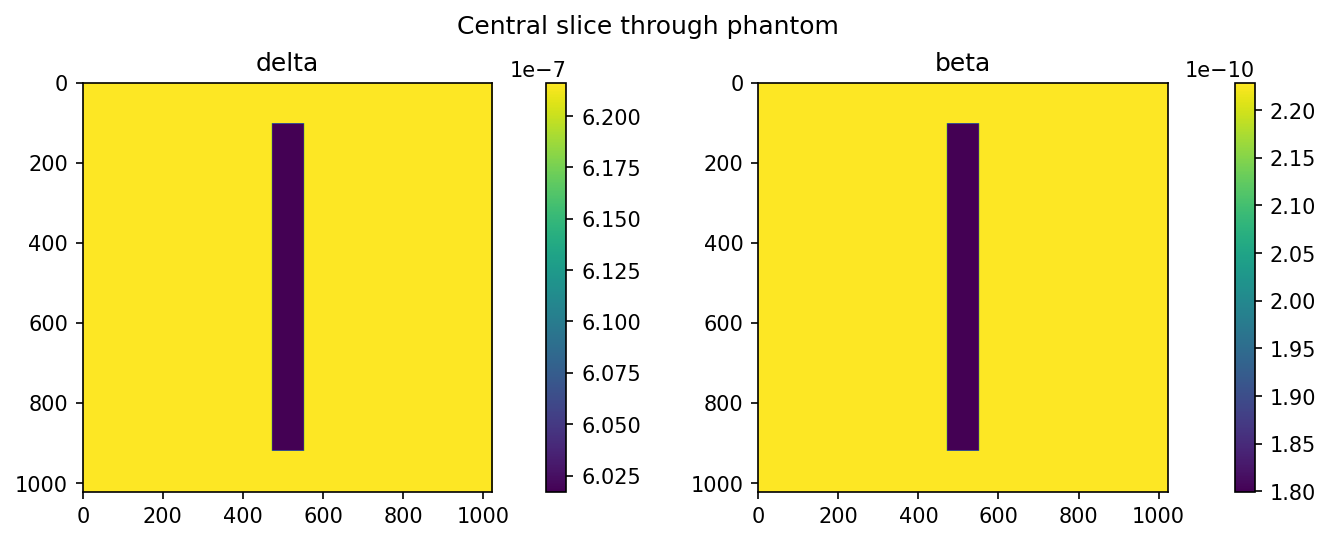

In [4]:
# Generate the phantom.
fiber_width = 50e-6 
obj_delta, obj_beta = make_fiber_phantom(N, Nz, dx, fiber_width, energy)

# Show.
fig, ax = plt.subplots(1, 2, figsize=[9,3.5], layout='constrained', dpi=150)
fig.suptitle('Central slice through phantom')
for i, obj in enumerate([obj_delta, obj_beta]):
    ax[i].set_title(['delta', 'beta'][i])
    m = ax[i].imshow(obj[obj.shape[0]//2,:,:])  
    fig.colorbar(m, ax=ax[i], pad=0)
plt.show()    

# Simulations

In [5]:
%%time

#####
# Incident field.
field = cx.plane_wave(
    shape = phantom_shape[1:], 
    dx = dx,
    spectrum = get_wavelen(energy),
    spectral_density = 1.0,
)
field = (field / field.intensity.max()**0.5)
cval = field.intensity.max()


#####
# Three different methods for modulating the wave through the phantom:
exit_fields = []

# method 1: native chromatix function `multislice_thick_sample`
exit_fields.append(
    cx.multislice_thick_sample(field, obj_beta, obj_delta, n_avg, dz, N_pad)
)

# method 2: sequentially repeating cx functions `thin_sample` and `transfer_propagate`
field_k = field      
for k in range(Nz):
    field_k = cx.thin_sample(field_k, obj_beta[k][None, ..., None, None], obj_delta[k][None, ..., None, None], dz)
    field_k = cx.transfer_propagate(field_k, dz, n_medium, N_pad, cval=cval, mode='same')
exit_fields.append(field_k)

# method 3: projection approximation `thin_sample` only.
beta_proj = dz * jnp.sum(obj_beta, axis=0)
delta_proj = dz * jnp.sum(obj_delta, axis=0)
exit_fields.append(
    cx.thin_sample(field, beta_proj[None, ..., None, None], delta_proj[None, ..., None, None], 1.0)
)


#####
# Apply the same free-space propagation method for each exit field:
imgs = []
for exit_field in exit_fields:
    det_field = cx.transfer_propagate(exit_field, propdist, n_medium, N_pad, cval=cval, mode='same')
    det_resample_func = init_plane_resample(det_shape, (det_dx, det_dx), resampling_method='linear')
    img = det_resample_func(det_field.intensity.squeeze()[...,None,None], field.dx.ravel()[:1])[...,0,0]
    img = img / (det_dx/dx)**2  # normalize counts to new pixel size
    imgs.append(img)


#####
# Extract the final images:
img_ms_chromatix = imgs[0]   # chromatix multislice
img_ms_seq = imgs[1]         # sequential multislice + propagation
img_approx = imgs[2]         # projection approximation only


CPU times: user 4.89 s, sys: 787 ms, total: 5.67 s
Wall time: 4.36 s


# Results for the three simulations

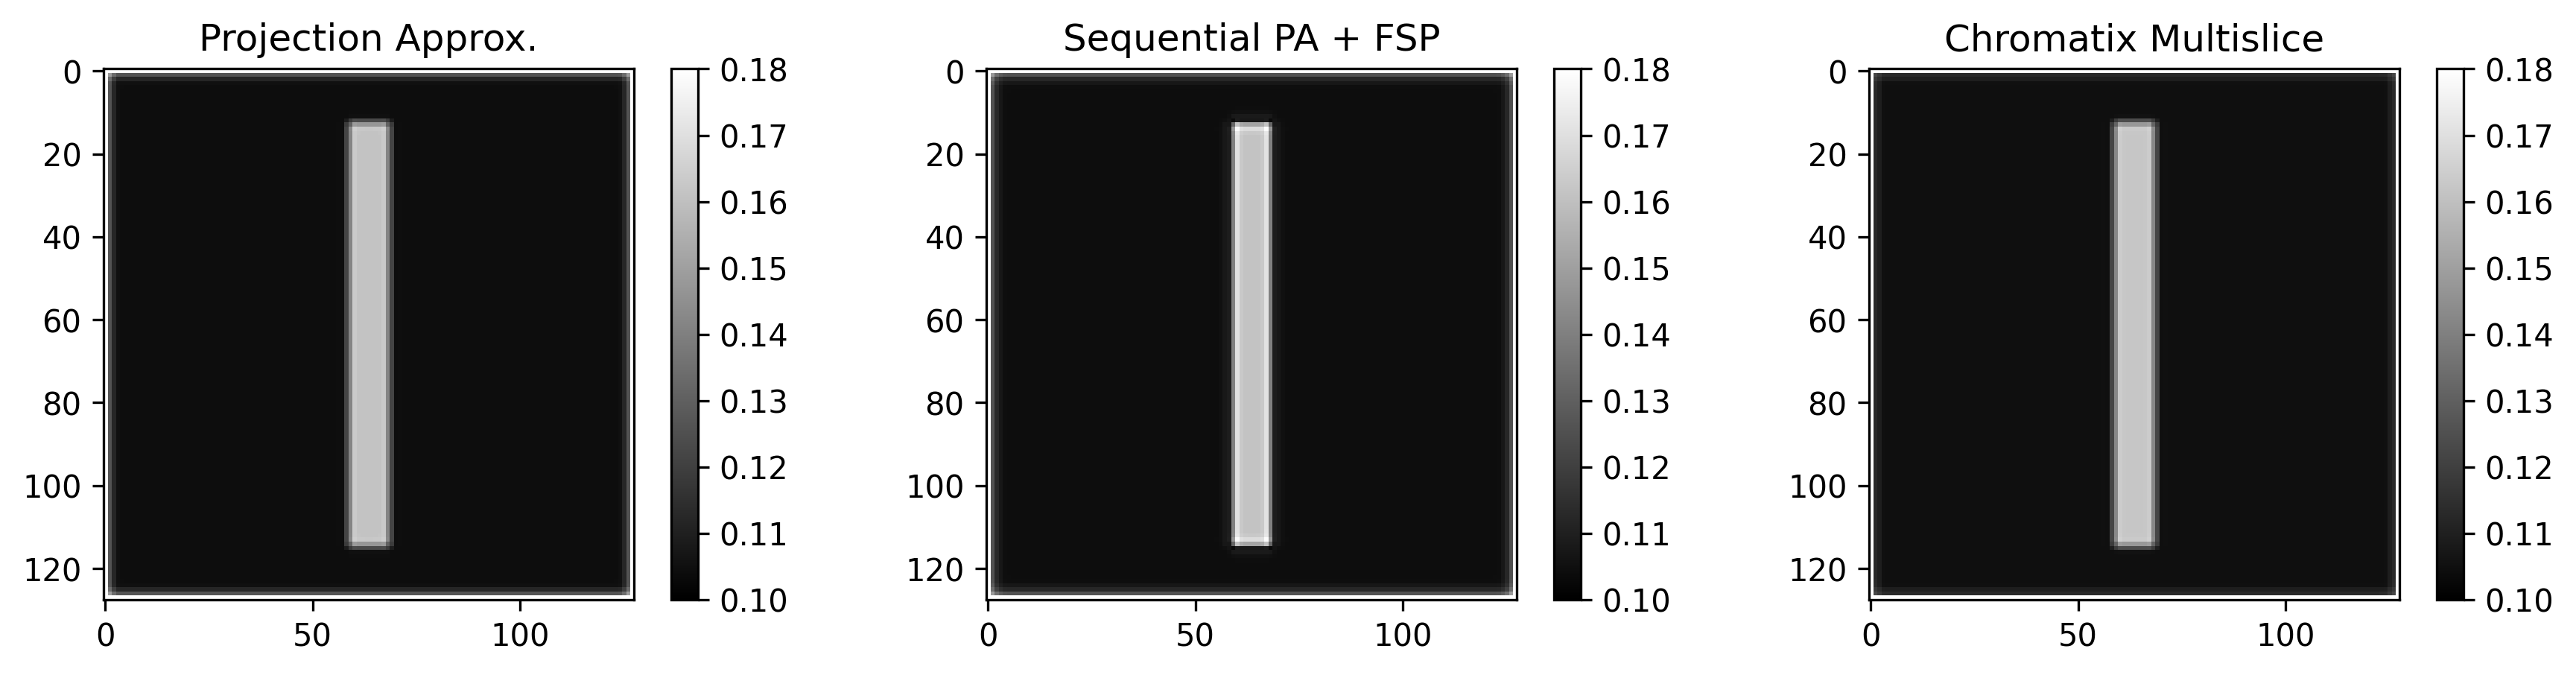

In [6]:
# Full images

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,3], dpi=300)
kw = {'cmap':'gray', 'vmin':0.1, 'vmax':0.18}


ax[0].set_title('Projection Approx.')
m = ax[0].imshow(img_approx, **kw)
fig.colorbar(m, ax=ax[0])

ax[1].set_title('Sequential PA + FSP')
m = ax[1].imshow(img_ms_seq, **kw)
fig.colorbar(m, ax=ax[1])

ax[2].set_title('Chromatix Multislice')
m = ax[2].imshow(img_ms_chromatix, **kw)
fig.colorbar(m, ax=ax[2])


fig.tight_layout()
plt.show()

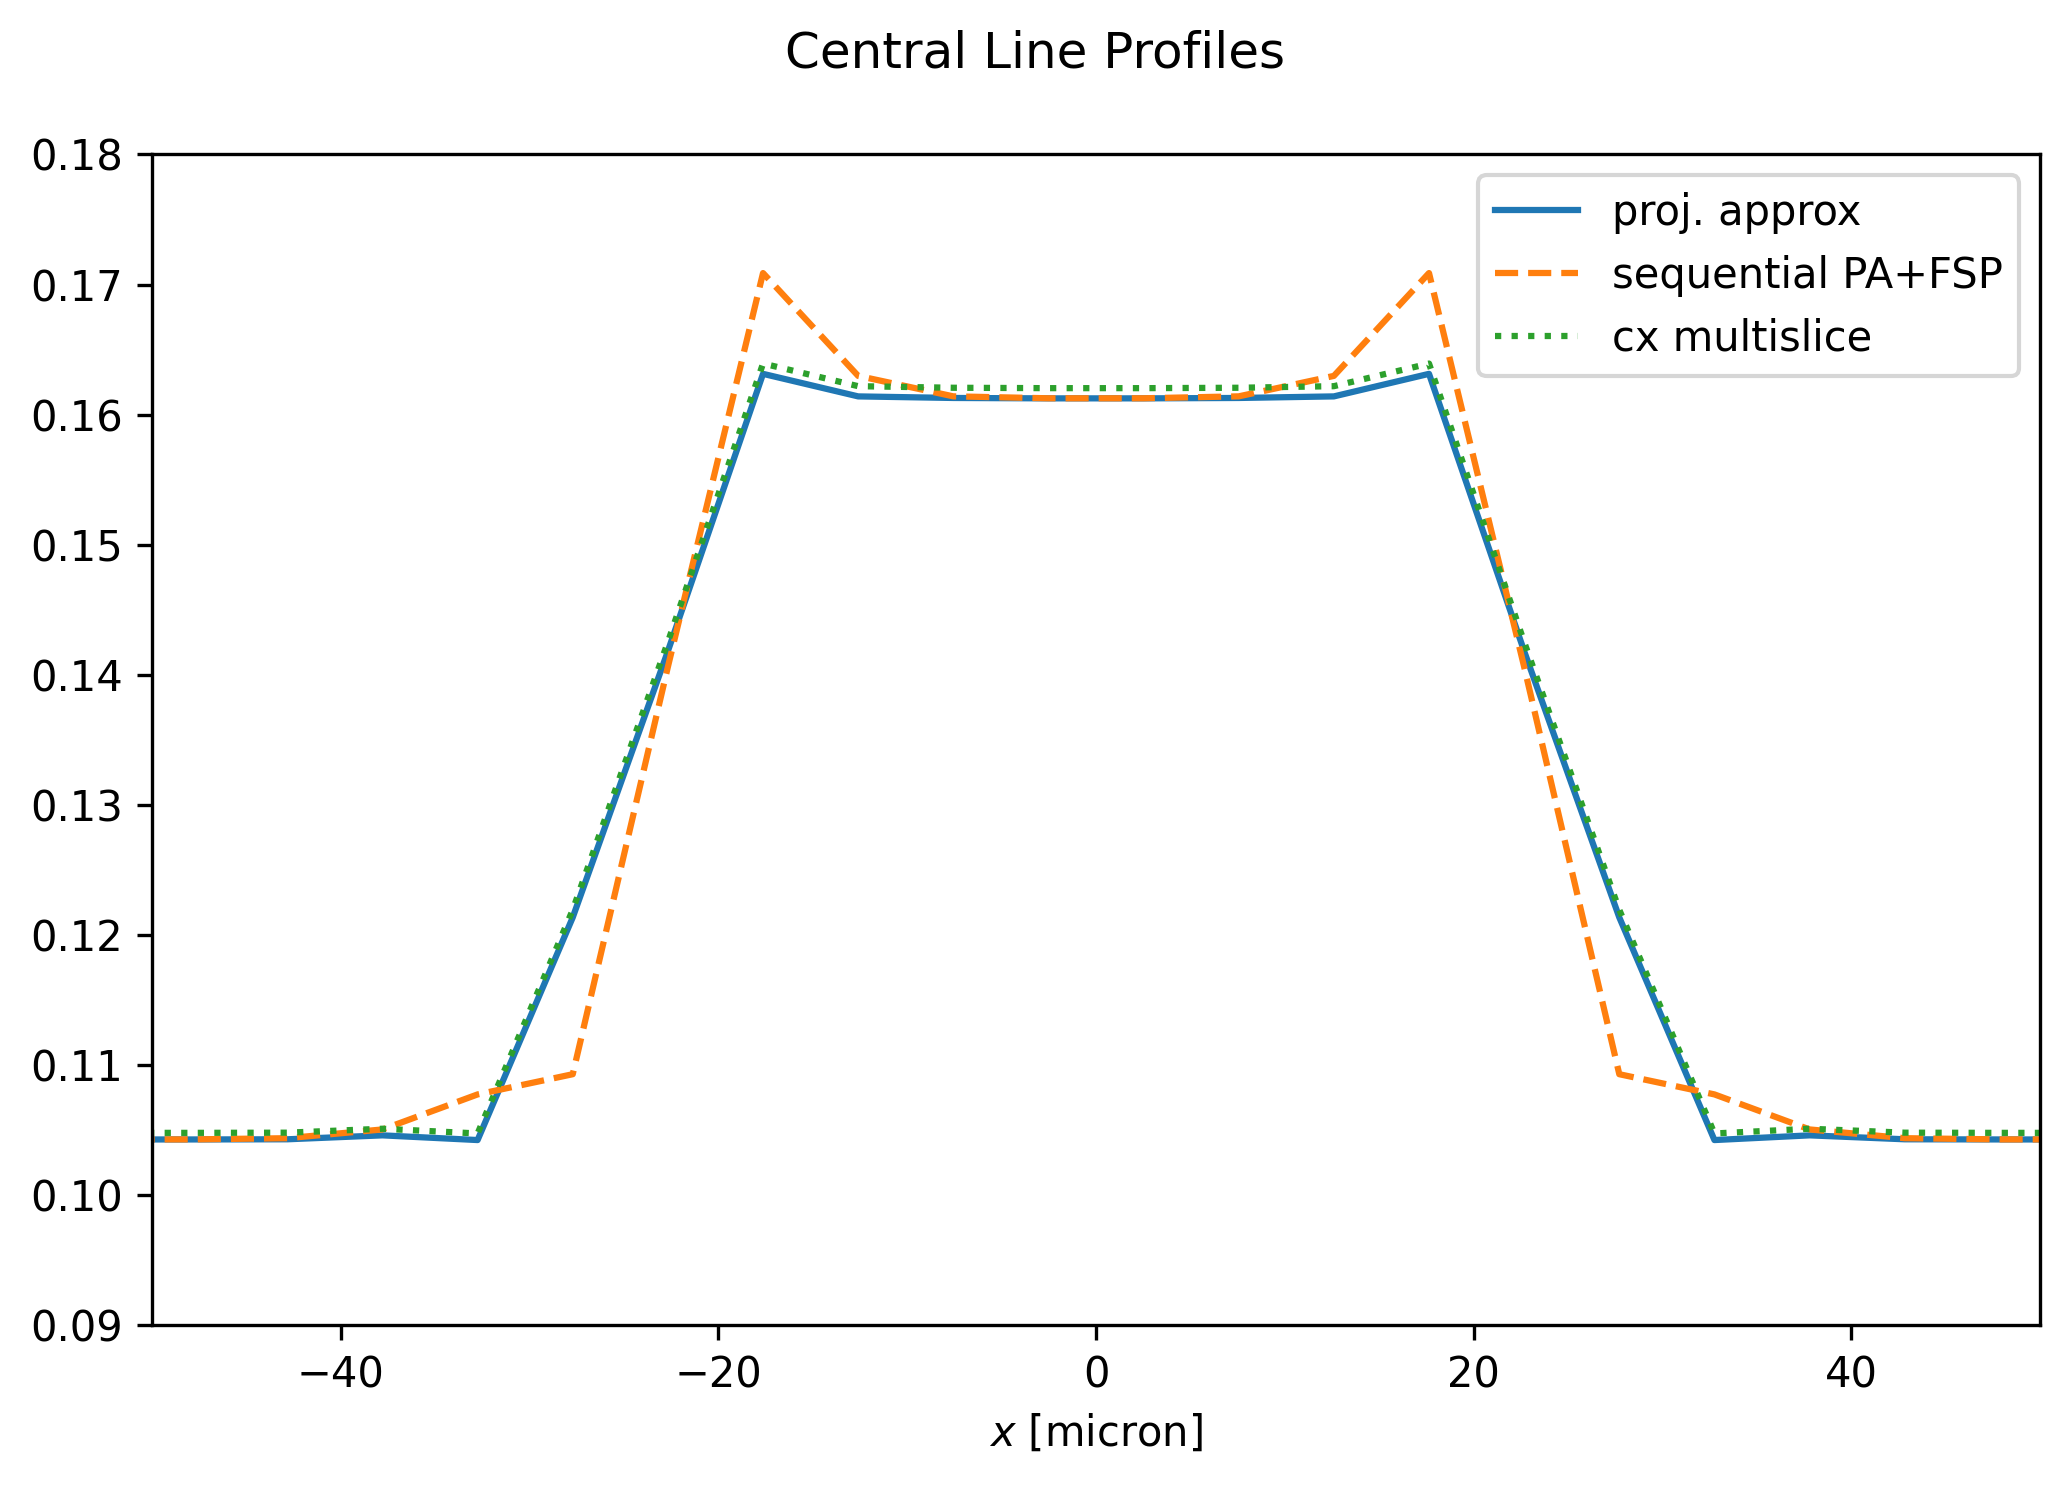

In [7]:
# Central line profiles better show the difference at the edges.

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7,5], dpi=300)

fig.suptitle('Central Line Profiles')
i_row = int((det_shape[0])/2)  
x = 1e6 * np.linspace(-fov/2, fov/2, det_shape[0])
ax.set_xlabel('$x$ [micron]')
ax.set_xlim(-fiber_width*1e6, fiber_width*1e6)  # zoom into the fiber width
ax.set_ylim(0.09, 0.18)
ax.plot(x, img_approx[i_row], linestyle='-', label='proj. approx') 
ax.plot(x, img_ms_seq[i_row], linestyle='--', label='sequential PA+FSP')  
ax.plot(x, img_ms_chromatix[i_row], linestyle=':', label='cx multislice')
ax.legend()
fig.tight_layout()
plt.show()

### Questions for Jan

* Why does `img_ms_seq` not match `img_ms_chromatix`? Visually comparing the outputs, `img_ms_chromatix` appears much more like `img_approx` than we expected.

* Which of the three padding calculator functions from chromatix.functional.propagation should we use: "exact", "transfer", or "transform"? https://chromatix.readthedocs.io/en/latest/api/functional/#chromatix.functional.propagation.compute_padding_exact 

* What is the difference between "absorption stack" and "absorption", and likewise the difference between "dn stack" and "dn"? Specifically within the context of the two functions "multislice_thick_sample" and "thin_sample". https://chromatix.readthedocs.io/en/latest/api/functional/#chromatix.functional.samples.multislice_thick_sample 